In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from typing import Tuple

In [2]:
photos_num = 4
photos = [cv2.imread('test-images/' + name, cv2.COLOR_BGR2RGB) for name in [
    'mountain_1.jpg',
    'mountain_2.jpg',
    'mountain_3.jpg',
    'mountain_4.jpg'
]]


In [3]:
def show_image(image: np.ndarray, fig_size: Tuple[int, int] = (10, 5)) -> None:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=fig_size)
    plt.imshow(image_rgb)
    plt.show()

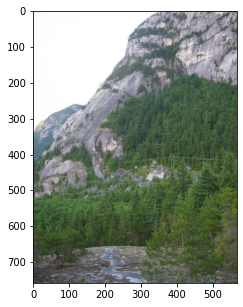

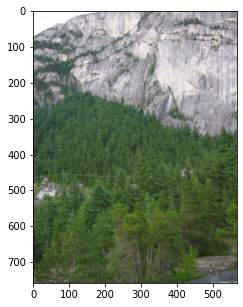

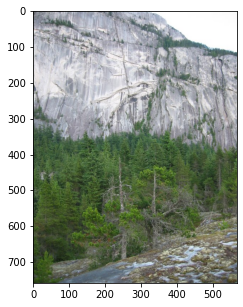

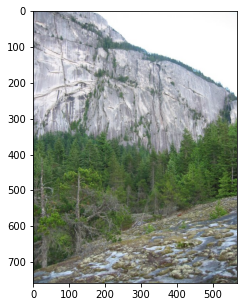

In [4]:
for photo in photos:
    show_image(photo)

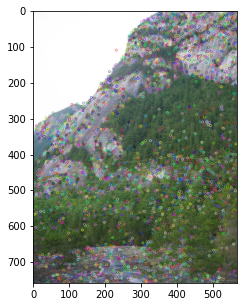

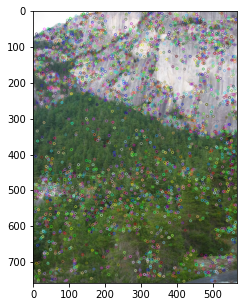

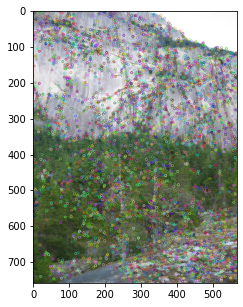

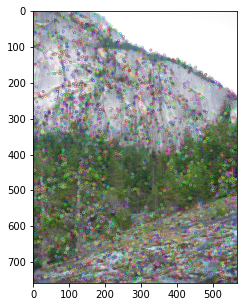

In [5]:
photos_grey = [cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY) for photo in photos]
sift = cv2.SIFT_create()
photos_sift_data = [sift.detectAndCompute(photo, None) for photo in photos_grey]
photos_with_keypoint = [np.empty_like(photo) for photo in photos]
for photo, photo_with_keypoint, (kps, des) in zip(photos, photos_with_keypoint, photos_sift_data):
    cv2.drawKeypoints(photo, kps, photo_with_keypoint)
    show_image(photo_with_keypoint)

reference_img_idx:  2


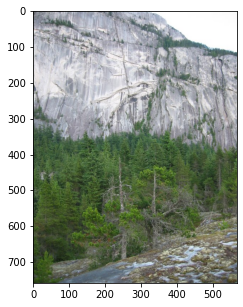

In [6]:
reference_img_idx = (photos_num) // 2
print("reference_img_idx: ", reference_img_idx)
reference_img = photos[reference_img_idx]
reference_img_kps, reference_img_des = photos_sift_data[reference_img_idx]
show_image(reference_img)

In [7]:
def find_matches(matcher, des_src, des_dst):
    return np.array([
        m for m in matcher.knnMatch(des_src, des_dst, k=2)
        if m[0].distance < 0.5 * m[1].distance
    ])
def find_homography(matches: np.ndarray, kp_src: np.ndarray, kp_dst: np.ndarray,
                    from_right_side: bool = True, img_src_width: int = None) -> np.ndarray:
    """
    Finds homography thransformation matrix
    """
    src = np.float32([ kp_src[m.queryIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    dst = np.float32([ kp_dst[m.trainIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    
    H, _ = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)

    return H

In [8]:
bf_matcher = cv2.BFMatcher()
featureList = [None] * photos_num
HList = [None] * photos_num
for i in range(reference_img_idx):
    kp_src, des_src = photos_sift_data[i]
    kp_dst, des_dst = photos_sift_data[i + 1]
    featureList[i] = find_matches(bf_matcher, des_src, des_dst)
    HList[i] = find_homography(featureList[i], kp_src, kp_dst, from_right_side=False, img_src_width=photos[i].shape[1])
for i in range(reference_img_idx + 1, photos_num):
    kp_src, des_src = photos_sift_data[i]
    kp_dst, des_dst = photos_sift_data[i - 1]
    featureList[i] = find_matches(bf_matcher, des_src, des_dst)
    HList[i] = find_homography(featureList[i], kp_src, kp_dst, from_right_side=False, img_src_width=photos[i].shape[1])
featureList[reference_img_idx] = []
featureNum = np.array([len(f) for f in featureList])
HList, featureNum 

([array([[ 1.21715174e+00, -3.33683460e-02, -3.58094849e+02],
         [ 1.83919165e-01,  1.13456992e+00, -1.77527891e+01],
         [ 4.12466407e-04, -6.20340020e-05,  1.00000000e+00]]),
  array([[ 1.32953794e+00, -1.04304965e-01, -4.77946433e+02],
         [ 3.10319188e-01,  1.25920828e+00, -1.31039938e+02],
         [ 5.91076920e-04, -3.06455787e-05,  1.00000000e+00]]),
  None,
  array([[ 8.86183718e-01,  3.80293287e-02,  1.72183030e+02],
         [-1.02813464e-01,  9.58561415e-01,  1.89935976e+01],
         [-1.91879553e-04,  7.51846144e-07,  1.00000000e+00]])],
 array([ 676,  478,    0, 1276]))

In [9]:
def stitch_images(img_src: np.ndarray, img_dst: np.ndarray, H: np.ndarray, from_right_side: bool = True) -> np.ndarray:
    """
    Stitced images from either left or right side
    (if `from_right_side` is set to False, then additional translation along x-axe will be added)
    """
    img_src_w, img_dst_w = img_src.shape[1], img_dst.shape[1]
    #     new_size = (img_src_w + img_dst_w), img_dst.shape[0]
        
    if not from_right_side:
        # shift by `img_src_width` px along x axe
        shift_vector = np.array([[1, 0, img_src_w]])
        H = H.copy()
        H[0, :] = np.dot(shift_vector, H)
    output = cv2.warpPerspective(img_src, H, img_dst.shape)
    if from_right_side:
        output[:, :img_dst_w] = img_dst
    else:
        output[:, img_dst_w:] = img_dst
    return output


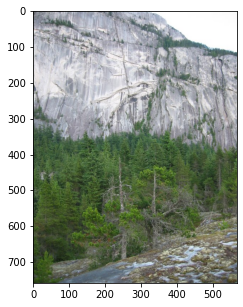

(None, (758, 568, 3))

In [10]:
show_image(reference_img), reference_img.shape

In [11]:
def create_panorama_canvas(img, img_idx, photos_num, padding=0):
    panorama = np.zeros((img.shape[0], img.shape[1] * (photos_num + padding * 2), img.shape[2]), dtype=np.uint8)
    panorama[:, img.shape[1] * (img_idx + padding): img.shape[1] * (img_idx + padding + 1)] = img
    return panorama

In [12]:
def stitch_images(img_src: np.ndarray, img_dst: np.ndarray, H: np.ndarray, from_right_side: bool = True, img_src_idx=None) -> np.ndarray:
    """
    Stitced images from either left or right side
    (if `from_right_side` is set to False, then additional translation along x-axe will be added)
    """
    img_src_w = img_src.shape[1]
    
    # shift along x axe
    if not from_right_side:
        shift_by_x = img_src_w * (reference_img_idx + 2)
    else:
        shift_by_x = img_src_w * (reference_img_idx + 2 + (img_src_idx - reference_img_idx - 1))
    shift_vector = np.array([[1, 0, shift_by_x]])
    H = H.copy()
    H[0, :] = np.dot(shift_vector, H)
    
    # apply transformation
    output = cv2.warpPerspective(img_src, H, (img_dst.shape[1], img_dst.shape[0]))

    # add panorama
    idx_x, idx_y, idx_z = np.where(img_dst != np.array([0, 0, 0]))
    output[idx_x, idx_y, idx_z] = img_dst[idx_x, idx_y, idx_z]

    return output


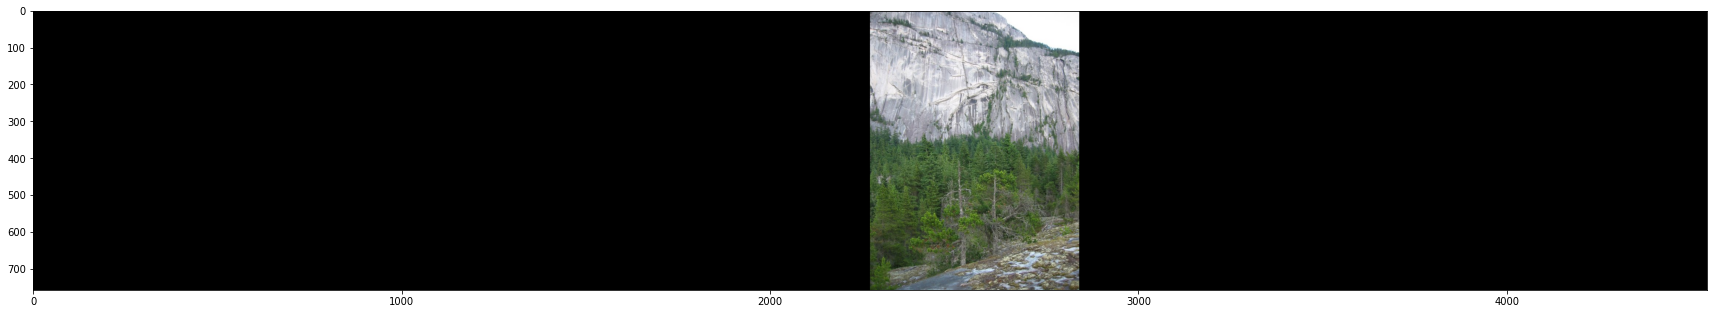

max_i: 3


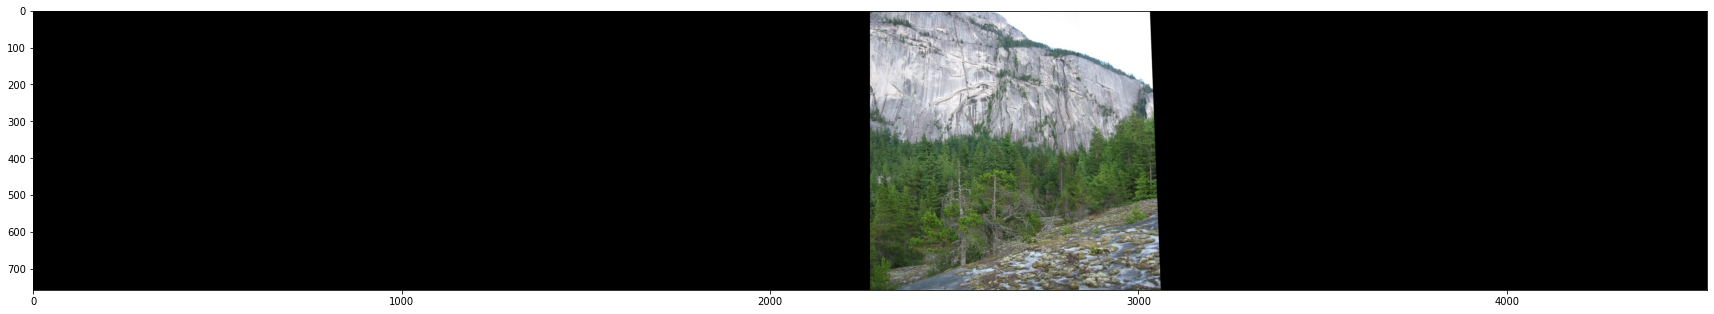

max_i: 0


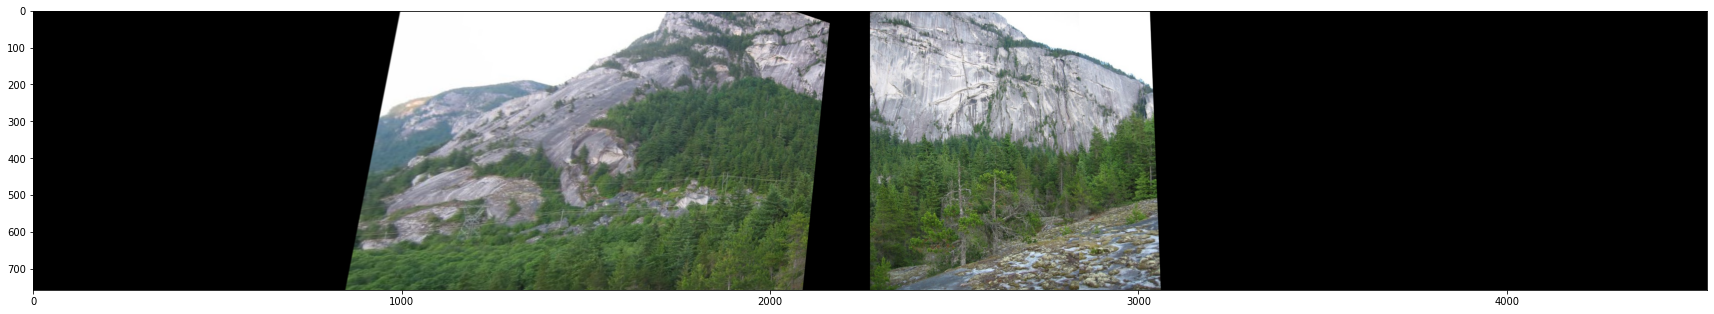

max_i: 1


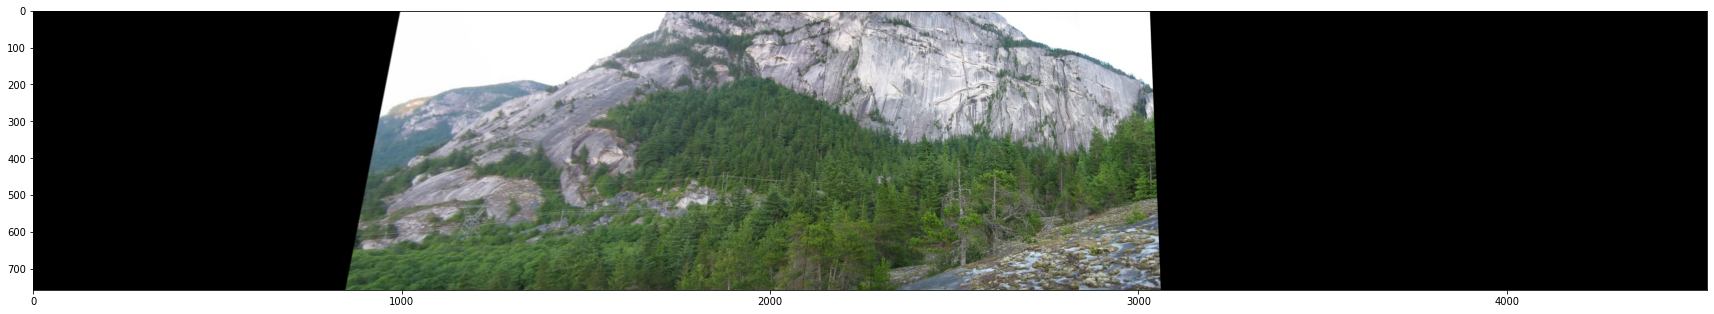

In [13]:
# simple memoization
HList_memoized = [None] * photos_num
featureNum_ = featureNum.copy()

panorama = create_panorama_canvas(reference_img, reference_img_idx, photos_num, padding=2)
show_image(panorama, fig_size=(30, 10))

for _ in range(photos_num - 1):
    max_i = np.argmax(featureNum_)
    H = HList[max_i]
    
    # calculate transformation using the property of transitivity of matrixes
    if max_i > reference_img_idx:
        range_ = range(max_i - 1, reference_img_idx + 1, -1)
    else:
        range_ = range(max_i + 1, reference_img_idx)

    for i in range_:
        # use memoized matrices if possible
        if HList_memoized[i] is not None:
            H = np.dot(HList_memoized[i], H)
            break
        H = np.dot(HList[i], H)

    HList_memoized[max_i] = H
    featureNum_[max_i] = -1
    
    # performe stitching
    print("max_i:", max_i)
    panorama = stitch_images(photos[max_i], panorama, H, from_right_side=(max_i > reference_img_idx), img_src_idx=max_i)
    show_image(panorama, fig_size=(30, 10))